In [32]:
%pip install numpy
%pip install pandas
%pip install scikit-learn==1.5.2
%pip install matplotlib
%pip install tensorflow
%pip install seaborn
%pip install scikeras
%pip install tf-keras
%pip install wordcloud
%pip install openpyxl
%pip install transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
Using cached tf_keras-2.19.0-py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
KAGGLE = False

In [4]:
if KAGGLE:
  SG2_PATH = '/kaggle/input/babe-media-bias-annotations-by-experts/data/final_labels_SG2.csv'
else:
  SG2_PATH = 'data/final_labels_SG2.csv'

df = pd.read_csv(SG2_PATH)

df.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,‘A new low’: Washington Post media critic blow...,https://www.alternet.org/2019/08/a-new-low-was...,Alternet,white-nationalism,left,Biased,Expresses writer’s opinion,"['blows', 'up', 'absurd', 'lies', 'nationalism..."


In [5]:
df['label_bias'].value_counts()

label_bias
Non-biased      1863
Biased          1810
No agreement       1
Name: count, dtype: int64

In [6]:
df.isnull().sum()

text              0
news_link        32
outlet            0
topic             0
type              0
label_bias        0
label_opinion     0
biased_words      0
dtype: int64

In [7]:
df.shape

(3674, 8)

In [8]:
# Only consider agreed upon labels
df = df[df['label_bias']!='No agreement']

Definiremos helper functions para obtener el score de bias. El criterio de score es el siguiente:

Tomando left = -1, center = 0, right = 1, bias como 0 o 1 (dependiendo del valor en la columna 'label_bias'), y la cantidad de palabras en 'biased_words' como el score, calculamos el score de bias como valor de bias * position * cantidad.

In [9]:
# Returns the bias score for a given row
def score_bias(row):
    biased_word_count = count_biased_words(row['biased_words'])
    position = 1 if row['type'] == 'right' else 0 if row['type'] == 'center' else -1
    bias = row['label_bias']
    return bias * position * biased_word_count

# Count number of biased words in a column. 
# This expects a specific type of string.
# See the parsing function.
def count_biased_words(col):
    if isinstance(col, str):
        col = parse_string_array(col)
    return len(col)

# Parses the column with biased words.
# This columns is in the form of a string: "['word1', 'word2']",
# and not a list.
def parse_string_array(col):
    if col == '[]':
        return []
    res = []
    col = col.strip('"')
    col = col.lstrip('[')
    col = col.rstrip(']')
    for word in col.split(','):
        res.append(word.strip("'"))
    return res

In [10]:
# Encode label bias, now that we have only 2 categories: biased and unbiased.
df_encoded = pd.get_dummies(df, columns=['label_bias'], drop_first=True).rename(columns={'label_bias_Non-biased':'label_bias'})
df_encoded['label_bias'] = (~df_encoded['label_bias']).astype(int)
df_encoded.head()

,text,news_link,outlet,topic,type,label_opinion,biased_words,label_bias
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Entirely factual,[],0
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",1
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']",1
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Somewhat factual but also opinionated,[],1
4,‘A new low’: Washington Post media critic blow...,https://www.alternet.org/2019/08/a-new-low-was...,Alternet,white-nationalism,left,Expresses writer’s opinion,"['blows', 'up', 'absurd', 'lies', 'nationalism...",1


In [11]:
df['Bias_Metric'] = df_encoded[['type', 'label_bias', 'biased_words']].apply(score_bias, axis=1)
df.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,Bias_Metric
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[],0
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",-2
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']",-3
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[],0
4,‘A new low’: Washington Post media critic blow...,https://www.alternet.org/2019/08/a-new-low-was...,Alternet,white-nationalism,left,Biased,Expresses writer’s opinion,"['blows', 'up', 'absurd', 'lies', 'nationalism...",-6


In [ ]:
df['topic'].value_counts().plot.bar()

<Axes: >

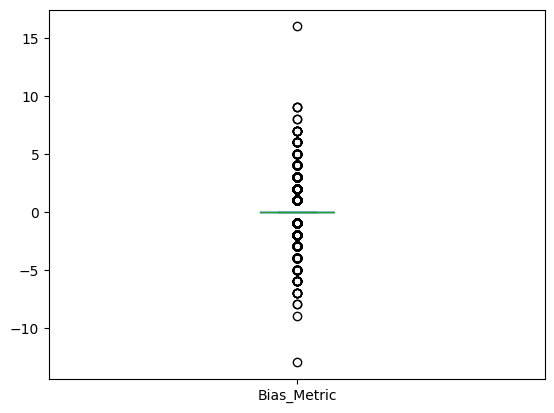

In [12]:
# Visualize the distribution of the bias metric
df['Bias_Metric'].plot.box()

In [13]:
# Remove 'center' articles with labeled as biased, since our score metric would score these as 0.
df = df[~((df["type"] == "center") & (df["label_bias"] == 1))]

In [14]:
# Additional features for the model
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['char_count'] = df['text'].apply(lambda x: len(x))

In [15]:
from scipy.stats import zscore

# Remove outliers
df[zscore(df['Bias_Metric']) > 4].shape
df_clean = df[zscore(df['Bias_Metric']) < 4]
df_clean.shape

(3667, 11)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

In [40]:
X = df_clean[['text', 'outlet', 'topic', 'word_count', 'char_count']]
y = df_clean['Bias_Metric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing phase, to transform text into numerical features and encode categorical features, was well as normalize numerical features
preprocessor = ColumnTransformer([
    ('text', TfidfVectorizer(max_features=5000), 'text'),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['outlet', 'topic']),
    ('num', StandardScaler(), ['word_count', 'char_count'])
])

# Pipeline for the model, first preprocessing the data, then define the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500, random_state=42, max_depth=10, min_samples_leaf=4, min_samples_split=10))
])
model.fit(X_train, y_train)
print("Train Score:", model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))

Train Score: 0.6997287876458034
Test Score: 0.5110218107121377


In [ ]:
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, model.predict(X_test)))

In [18]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.svm import SVR, LinearSVR

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # A stacking regressor, combining Random Forest and Gradient Boosting models as base models
# base_models = [
#     ('f', Pipeline([('preprocessor', preprocessor), ('clf', RandomForestRegressor(n_estimators=500, random_state=42, max_depth=10, min_samples_leaf=4, min_samples_split=10))])),
#     ('s', Pipeline([('preprocessor', preprocessor), ('gbr', GradientBoostingRegressor(n_estimators=500, random_state=42))])),
# ]

# # Define meta-model, a Ridge model
# meta_model = Ridge()

# stacking_reg = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# stacking_reg.fit(X_train, y_train)
# print("Stacking Regressor R² Score:", stacking_reg.score(X_test, y_test))

### Neural Network Approach

In [19]:
%pip install keras
%pip install scikeras


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [20]:
import tensorflow as tf
import keras
import scikeras
import sklearn
print("Keras Version:", keras.__version__)
print("TensorFlow Version:", tf.__version__)
print("Scikeras Version:", scikeras.__version__)
print("sklearn Version:", sklearn.__version__)

Keras Version: 3.9.1
TensorFlow Version: 2.19.0
Scikeras Version: 0.13.0
sklearn Version: 1.5.2


In [21]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

X = df_clean[['text', 'outlet', 'topic', 'word_count', 'char_count']]
y = df_clean['Bias_Metric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape, y_test.shape)

(734, 5) (734,)


In [64]:
text_vectorizer = TfidfVectorizer(max_features=10000)
cat_encoder = OneHotEncoder(handle_unknown='ignore')
num_scaler = StandardScaler()

X_text_train = text_vectorizer.fit_transform(X_train['text']).toarray()
X_cat_train = cat_encoder.fit_transform(X_train[['outlet', 'topic']]).toarray()
X_num_train = num_scaler.fit_transform(X_train[['word_count', 'char_count']])

X_text_test = text_vectorizer.transform(X_test['text']).toarray()
X_cat_test = cat_encoder.transform(X_test[['outlet', 'topic']]).toarray()
X_num_test = num_scaler.transform(X_test[['word_count', 'char_count']])

X_train_transformed = np.hstack([X_text_train.astype(np.float32), 
                                 X_cat_train.astype(np.float32), 
                                 X_num_train.astype(np.float32)])

X_test_transformed = np.hstack([X_text_test.astype(np.float32), 
                                X_cat_test.astype(np.float32), 
                                X_num_test.astype(np.float32)])

def create_nn(optimizer='nadam', neurons1=512, neurons2=256, dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=X_train_transformed.shape[1]))
    model.add(Dense(neurons1 // 2, activation='relu'))
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dense(neurons2 // 2, activation='relu'))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [65]:
from keras.callbacks import EarlyStopping
nn_model = KerasRegressor(model=create_nn, verbose=1, batch_size=64, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/100


c:\Users\petur\miniforge3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 2.0550
Epoch 2/100
 2/46 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.8081

c:\Users\petur\miniforge3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.7677
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.2163
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.1261
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0755
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0419
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0277
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0207
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0210
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0233
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0211
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0211
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0183
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0284
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0194
Epoch 16/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0197


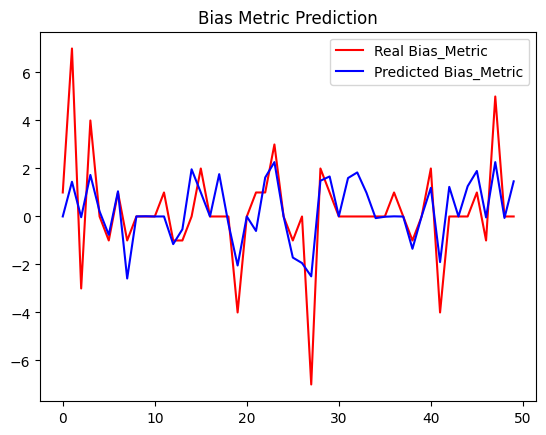

In [66]:
nn_model.fit(X_train_transformed, y_train)

y_pred = nn_model.predict(X_test_transformed)

plt.plot(y_test.values[:50], color='red', label='Real Bias_Metric')
plt.plot(y_pred[:50], color='blue', label='Predicted Bias_Metric')
plt.title('Bias Metric Prediction')
plt.legend()
plt.show()

In [67]:
# accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred.round())
print("Accuracy:", accuracy)

Accuracy: 0.5449591280653951


In [68]:
# r2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

R2 Score: 0.5106295347213745


In [69]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

MSE: 1.4499594429562812


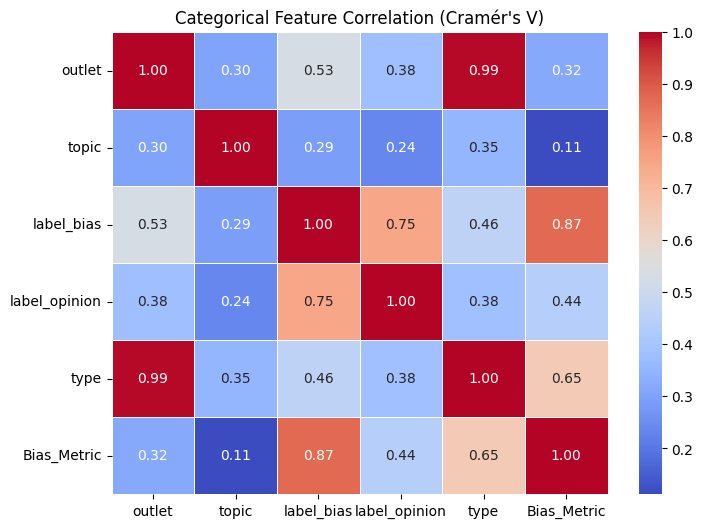

In [28]:
import numpy as np
import scipy.stats as stats
import seaborn as sns

def cramers_v(x, y):
    """
    Calculate Cramer's V statistic for 2 categorical variables
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def categorical_correlation(df, categorical_cols):
    """
    Calculate and plot categorical feature correlation
    """
    cat_corr = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                cat_corr.loc[col1, col2] = 1.0
            else:
                cat_corr.loc[col1, col2] = cramers_v(df[col1], df[col2])
    cat_corr = cat_corr.astype(float)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cat_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Categorical Feature Correlation (Cramér's V)")
    plt.show()

categorical_cols = ["outlet", "topic", "label_bias", "label_opinion", "type", "Bias_Metric"]
categorical_correlation(df, categorical_cols)

In [29]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokens = tokenizer(df["text"].tolist(), 
                   padding=True, truncation=True, 
                   max_length=64, return_tensors="tf")

print(tokens.input_ids.shape)

c:\Users\petur\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(3673, 64)


In [33]:
from transformers import TFBertModel

base_model = TFBertModel.from_pretrained("bert-base-uncased")
input_ids = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name="attention_mask")
bert_output = base_model(input_ids, attention_mask=attention_mask).pooler_output
output = tf.keras.layers.Dense(1, activation="tanh")(bert_output)  # Output range (-1, 1)
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss="mse", metrics=["mae"])
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 64, 76                                       

In [38]:
train_texts, val_texts, train_scores, val_scores = train_test_split(X["text"], y, test_size=0.2, random_state=42)
train_tokens = tokenizer(train_texts.tolist(), padding=True, truncation=True, max_length=64, return_tensors="tf")
val_tokens = tokenizer(val_texts.tolist(), padding=True, truncation=True, max_length=64, return_tensors="tf")

history = model.fit(
    x={"input_ids": train_tokens["input_ids"], "attention_mask": train_tokens["attention_mask"]},
    y=tf.convert_to_tensor(train_scores),
    validation_data=(
        {"input_ids": val_tokens["input_ids"], "attention_mask": val_tokens["attention_mask"]}, 
        tf.convert_to_tensor(val_scores)
    ),
    epochs=3,
    batch_size=8
)

Epoch 1/3


367/367 [==============================] - 1475s 4s/step - loss: 2.7467 - mae: 1.0640 - val_loss: 2.7825 - val_mae: 1.0876
Epoch 2/3
367/367 [==============================] - 1255s 3s/step - loss: 2.2940 - mae: 0.9725 - val_loss: 2.4306 - val_mae: 1.0025
Epoch 3/3
367/367 [==============================] - 1360s 4s/step - loss: 1.8643 - mae: 0.8540 - val_loss: 2.4256 - val_mae: 0.9540


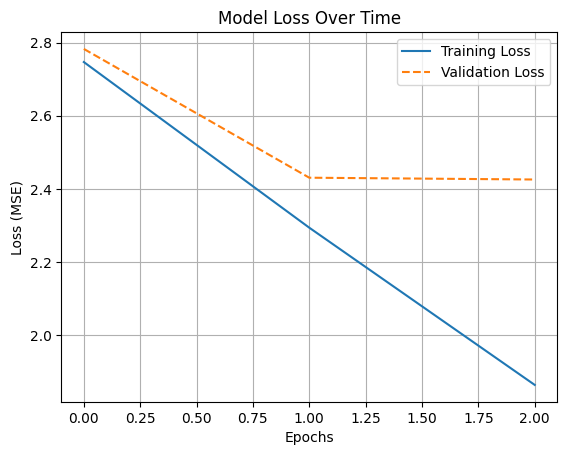

In [39]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()